# Creating CNN Model for Classification of Convective Mode

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

## The Data

In [2]:
#set input values
num_classes = 6
input_shape = (136, 136, 1)

#create the training, validation, testing splits
x_train = np.load("train_imgs_1996-2011.npy")
y_train = np.load("train_classes_1996-2011.npy")

x_val = np.load("validation_imgs_2012-2013.npy")
y_val = np.load("validation_classes_2012-2013.npy")

x_test = np.load("test_imgs_2014-2017.npy")
y_test = np.load("test_classes_2014-2017.npy")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [3]:
#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

In [4]:
#Test if tensorflow is using GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus

2023-05-17 19:52:51.157418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 19:52:51.166697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 19:52:51.166868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
#create the model
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

keras.utils.plot_model(model, show_shapes=True)

2023-05-17 19:52:51.200816: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 19:52:51.202557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 19:52:51.202726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-17 19:52:51.202856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Data Augmentation

<AxesSubplot:xlabel='km', ylabel='km'>

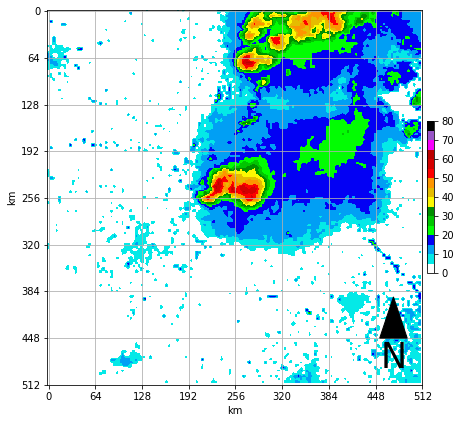

In [6]:
#Plot one of the images
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

from svrimg.mapping.map_helper import radar_colormap, draw_box_plot
from matplotlib.colors import BoundaryNorm

cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

sample = x_test[136]
ax = plt.subplot(1,1,1)
draw_box_plot(ax, sample.squeeze()*80)

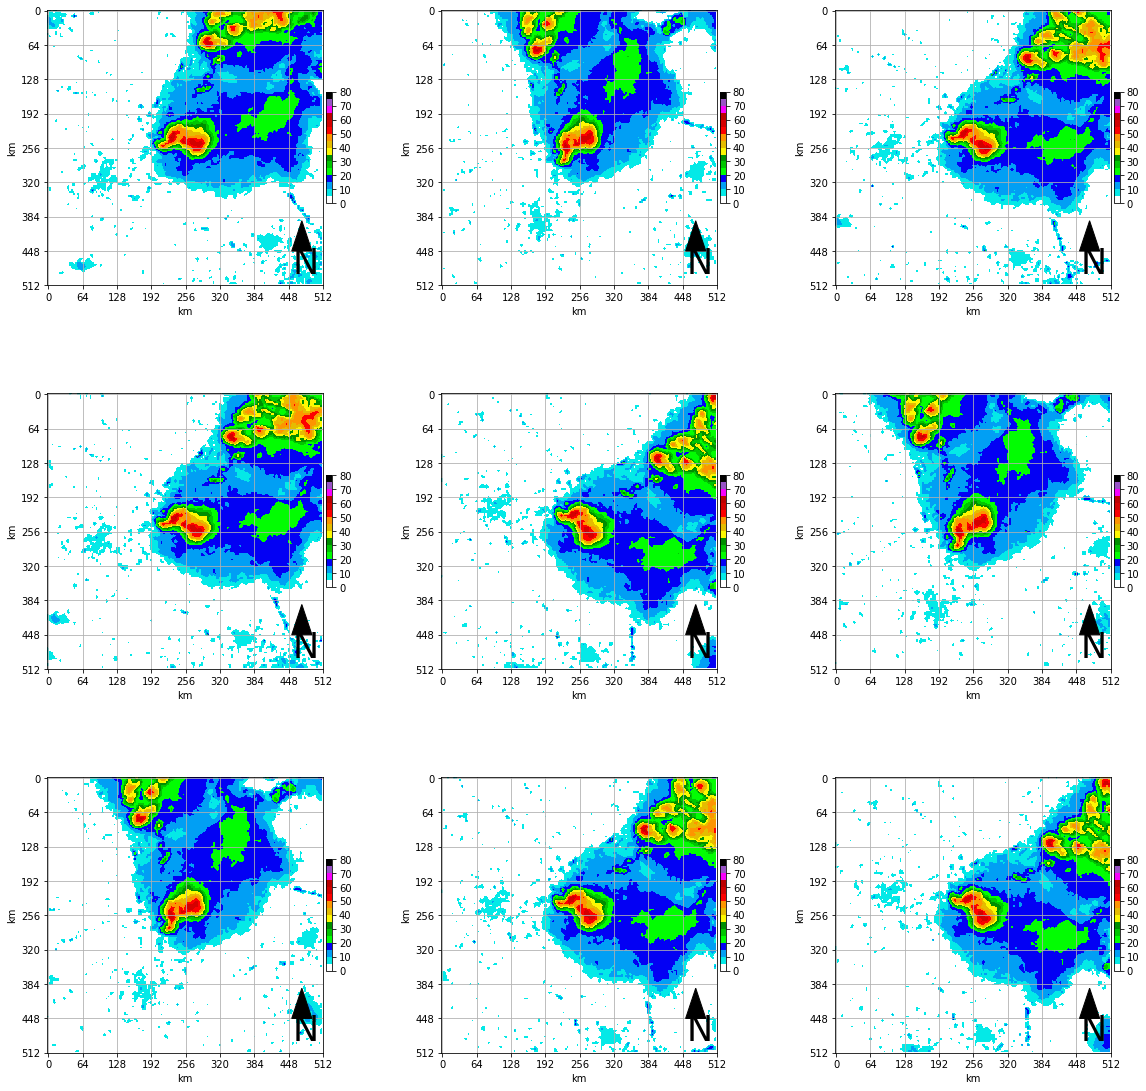

In [7]:
#Augment the data by rotating the image around the centroid.
#plot these images being rotated for visualization purposes. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

plt.rcParams['figure.figsize'] = 20, 20
samples = expand_dims(sample, 0)
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")
aug_imgs = datagen.flow(samples, batch_size=1)

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    batch = aug_imgs.next()
    draw_box_plot(ax, batch[0].squeeze()*80)

## Training the Model

In [8]:
#train the model
epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/100


2023-05-17 19:52:56.323422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500


  1/143 [..............................] - ETA: 5:35 - loss: 1.8092 - accuracy: 0.1562

2023-05-17 19:52:56.805640: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - 7s 30ms/step - loss: 1.4223 - accuracy: 0.3906 - val_loss: 0.9028 - val_accuracy: 0.6731
Epoch 2/100
143/143 [==============================] - 4s 29ms/step - loss: 1.0776 - accuracy: 0.5445 - val_loss: 0.7309 - val_accuracy: 0.7023
Epoch 3/100
143/143 [==============================] - 4s 29ms/step - loss: 0.9617 - accuracy: 0.6171 - val_loss: 0.6088 - val_accuracy: 0.8220
Epoch 4/100
143/143 [==============================] - 4s 29ms/step - loss: 0.8504 - accuracy: 0.6511 - val_loss: 0.7203 - val_accuracy: 0.6861
Epoch 5/100
143/143 [==============================] - 4s 28ms/step - loss: 0.7913 - accuracy: 0.6789 - val_loss: 0.6347 - val_accuracy: 0.7670
Epoch 6/100
143/143 [==============================] - 4s 29ms/step - loss: 0.7468 - accuracy: 0.7057 - val_loss: 0.6436 - val_accuracy: 0.7249
Epoch 7/100
143/143 [==============================] - 4s 28ms/step - loss: 0.7208 - accuracy: 0.7145 - val_loss: 0.3813 - val_accuracy: 0.8803
Epoc

## Model Peformance

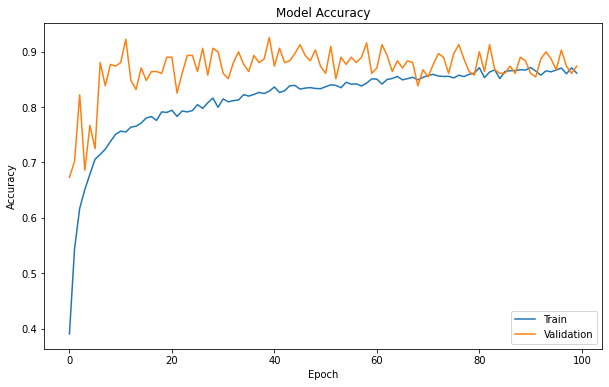

In [9]:
#plot the training and validation accuracy
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [10]:
#show some performance metrics
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.29803842306137085
Test accuracy: 0.885869562625885


Confusion Matrix
[[ 30  31   0   0   0   0]
 [  2  76   3   0   0   0]
 [  0  11  58   5   0   1]
 [  0   1   7  58   3   7]
 [  0   0   0   4 480  30]
 [  0   0   0   0   0 113]]
Classification Report
              precision    recall  f1-score   support

    Cellular       0.94      0.49      0.65        61
        QLCS       0.64      0.94      0.76        81
    Tropical       0.85      0.77      0.81        75
       Other       0.87      0.76      0.81        76
     Missing       0.99      0.93      0.96       514
       Noise       0.75      1.00      0.86       113

    accuracy                           0.89       920
   macro avg       0.84      0.82      0.81       920
weighted avg       0.91      0.89      0.89       920



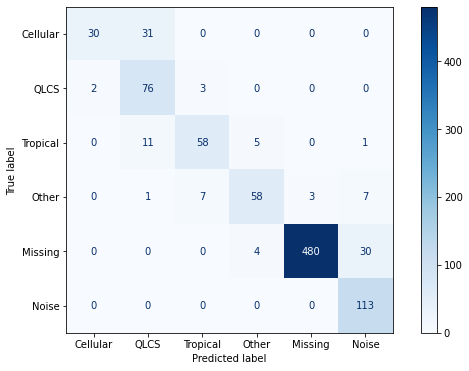

In [11]:
#create a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

target_names = ['Cellular', 'QLCS', 'Tropical', 'Other', 'Missing', 'Noise']

print('Confusion Matrix')
cm = confusion_matrix(y_test_, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
print('Classification Report')

print(classification_report(y_test_, y_pred, target_names=target_names))
disp.plot(cmap='Blues')

In [13]:
#save the model
model.save("/home/jovyan/Unidata/model/COM_model_v01.h5")